# AutoEQ on demand - for speakers
### with TCPi Channel and ESP32 as Server

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from pathfinder import Pathfinder

# abs_paths = ['']
# Pathfinder.relative_paths_from_abs(abs_paths)

relative_paths = [['..', '..', '..', '..', 'SigmaDSP', 'bitbucket', 'github', 'codes'],
                  ['..', '..', '..', '..', 'Signal Generators', 'bitbucket', 'github', 'codes'],
                  ['..', '..', '..', '..', 'Utilities', 'bitbucket', 'github', 'codes'], 
                  ['..', '..', '..', '..', 'TCPi', 'bitbucket', 'github', 'codes']] 

Pathfinder.append_relative_paths(relative_paths)
# =====================================================

import pandas as pd

#https://thispointer.com/python-pandas-how-to-display-full-dataframe-i-e-print-all-rows-columns-without-truncation/
pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)
# =====================================================

## TCPi

import time 

from tcpi.protocols.TCPIP1701 import class_finder
# =====================================================

### Client

from tcpi.bus.tcpi_client import I2C as TcpI2C_client

tcpi_client = TcpI2C_client(class_finder)
server_ip = '192.168.203.36'
tcpi_client.connect(server_ip = server_ip, server_port = 8086)
time.sleep(1)
# =====================================================

## DSP processor

from sigma.sigma_dsp.adau import ADAU1401

# dsp = ADAU1401(bus = bus)
dsp = ADAU1401(bus = tcpi_client)
# =====================================================


[Connecting server: ('192.168.203.36', 8086)]

[Connected with server: ('192.168.203.36', 8086)]


## SigmaStudio project file

In [3]:
import os

SigmaStudio_project_file_url = os.sep.join(['..', 'SigmaStudio projects', 'projects', 'demo', 'demo.dspproj'])
SigmaStudio_project_file_url

'..\\SigmaStudio projects\\projects\\demo\\demo.dspproj'

![](https://github.com/Wei1234c/DRC/blob/master/SigmaStudio%20projects/projects/demo/demo.png?raw=true)

## Factory

In [4]:
import os
from sigma.factory import Factory 

project_xml_file_url = os.sep.join(['..', 'SigmaStudio projects', 'projects', 'demo', 'demo.xml'])
class_files_root_url = os.sep.join(['..', '..', '..', '..', 'SigmaDSP', 'bitbucket', 'github', 'codes', 'sigma', 'sigma_studio', 'toolbox', 'cells']) 

factory = Factory(project_xml_file_url = project_xml_file_url,
                  class_files_root_url = class_files_root_url,
                  dsp = dsp
                 )

## IC

In [5]:
# showing cells, algorithms, parameters of this project

ic = factory.get_ic()
# ic.df

## Cells 

In [6]:
cells = factory.get_cells(ic)

### Get Cell objects ready for use.

In [7]:
# # un-comment this to generate a script to embody Cell objects.

# for o in factory.get_cells_manifest():
#     print(o) 

In [8]:
# assign variable names to each Cell for easy access.

delay0 = cells['Delay0']  # Fractional Delay( 1 )
delay1 = cells['Delay1']  # Fractional Delay( 1 )
fir0 = cells['FIR0']  # FIR( 1 )
fir1 = cells['FIR1']  # FIR( 1 )
gain0 = cells['Gain0']  # Gain (no slew)( 1 )
gain1 = cells['Gain1']  # Gain (no slew)( 1 )
invert0 = cells['Invert0']  # Invert( 1 )
invert1 = cells['Invert1']  # Invert( 1 )
merger0 = cells['Merger0']  # Signal MixerC
merger1 = cells['Merger1']  # Signal MixerC
mute00 = cells['Mute00']  # No Slew (Standard)( 1 )
mute01 = cells['Mute01']  # No Slew (Standard)( 1 )
mute10 = cells['Mute10']  # No Slew (Standard)( 1 )
mute11 = cells['Mute11']  # No Slew (Standard)( 1 )
param_eq0 = cells['Param EQ0']  # PEQ1Chan - Double Precision( 1 )
param_eq1 = cells['Param EQ1']  # PEQ1Chan - Double Precision( 1 )
pink_flt1 = cells['Pink Flt1']  # Pink Noise Filter( 1 )
source_switch = cells['Source_Switch']  # Stereo SW Slew( 3 )
sw_noise = cells['SW_noise']  # Mono SW Slew( 2 )
tone = cells['Tone']  # Tone Synthesis (lookup/sine)( 1 )
white_noise = cells['White_Noise']  # White Noise( 1 )

# Procedures

In [9]:
channels = {'left' : {'idx_channel': 0,
                      'muter': mute00,
                      'gain' : gain0,
                      'delay': delay0,
                      'peq'  : param_eq0,
                      'fir'  : fir0},
            'right': {'idx_channel': 1,
                      'muter': mute11,
                      'gain' : gain1,
                      'delay': delay1,
                      'peq'  : param_eq1,
                      'fir'  : fir1}}

def mute_all(value = True):
    for channel in channels.values():
        channel['muter'].mute(value)
        
def source_select_white_noise():
    source_switch.switch(1)
    invert1.enable(False)
    sw_noise.switch(1)
    
def source_select_normal():
    source_switch.switch(2)
    mute_all(False)

def measure_channel(channel_name):
    mute_all(True)
    source_select_white_noise()
    channels[channel_name]['muter'].mute(False)
    
def set_peq_coeffs(channel_name, coeffs):   
    muter = channels[channel_name]['muter'] 
    muter.mute(True)
    channels[channel_name]['peq'].set_coefficients_values(coeffs)
    muter.mute(False)    

def reset_peq_coeffs(channel_name):   
    muter = channels[channel_name]['muter'] 
    muter.mute(True)
    channels[channel_name]['peq'].reset_coefficients()
    muter.mute(False)

# Frequency Response Tuning

In [10]:
from pathfinder import Pathfinder

relative_paths = [['..', '..', '..', '..', '..', '..', '資料科學', 'Allen Downey', 'Think DSP', 'code'],
                  ['..', '..', '..', '..', 'AutoEq'],
                  ['..', 'codes']]

Pathfinder.append_relative_paths(relative_paths)

from drc.tuners.response.equalizer import ResponseEqualizer
from drc.measurements import Sampler
from drc.measurements.frequency.responses import FrequencyResponse
from drc.filters.peq import PEQs

# Microphone settings

In [11]:
from drc.measurements.frequency.calibrations.miniDSP import UMIK1


fn_calibration = 'UMIK-1 cal file 7103946.txt'
# fn = 'UMIK-1 cal file 7103946_90deg.txt'

mic = UMIK1()
mic.load(file_name = fn_calibration, n_header_lines = 2)
calibration = FrequencyResponse('mic', mic.fs, mic.amps)

# Utilities for sampling

In [12]:
# from pprint import pprint

# pprint(Sound.scan_devices(0))

In [13]:
def probe():      
    return Sampler.get_frequency_response(input_device_idx = 1, 
                                          framerate = 48000, 
                                          freq_lims = (20, 20000),
                                          sensitivity_dB = mic.sensitivity_dBFS,
                                          gain_dB = mic.gain_dB,
                                          calibration = calibration)

def probe_channels(wait_sec = 2):
    
    for channel_name in channels.keys():
    
        measure_channel(channel_name)
        time.sleep(wait_sec) 
        
        fr, _ = probe()        
        fr.name = channel_name
        fr.plot_graph(raw_plot_kwargs= {'color': 'green', 'alpha': 0.5},
                      smoothed_plot_kwargs= {'color': 'red', 'alpha': 0.5});

# Reset PEQ filters

In [14]:
for channel_name in channels.keys():
    reset_peq_coeffs(channel_name)  

C:\Softwares\Python\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


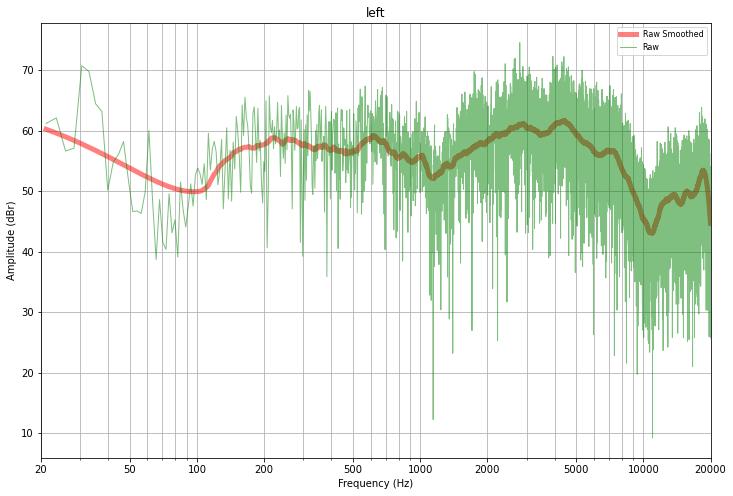

C:\Softwares\Python\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


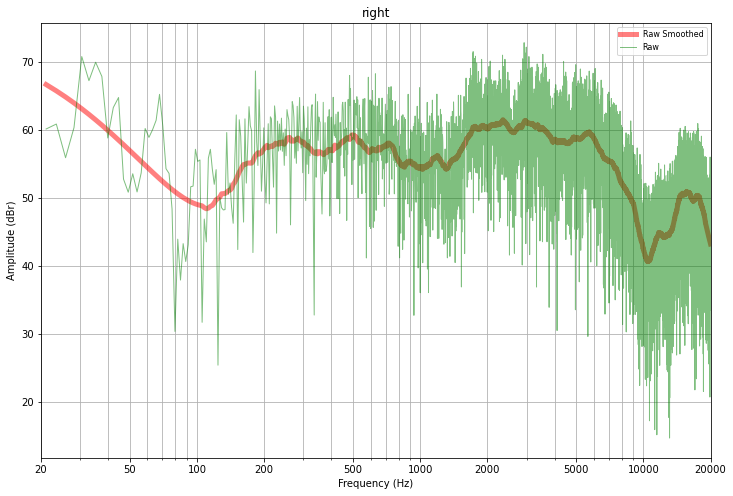

In [15]:
probe_channels()

# Calculate and apply PEQ coefficients 

In [16]:
model_name = 'JamBox'

In [17]:
import time


n_filters = 10
max_gain_dB = 12
bass_boost_gain = 0


def equalize(channel_name, compensation,
             n_filters = n_filters, max_gain_dB = max_gain_dB, bass_boost_gain = bass_boost_gain,
             wait_sec = 2):

    measure_channel(channel_name)
    time.sleep(wait_sec)

    _, fr_measurement = probe()

    measurement, peqs, n_peq_filters, peq_max_gains = \
        ResponseEqualizer.get_peq_filters(fr_measurement,
                                          compensation,
                                          max_filters = n_filters,
                                          max_gain_dB = max_gain_dB,
                                          bass_boost_gain = bass_boost_gain)
    
    peqs.dump(f'{model_name} {channel_name} PEQ filters.txt')
    set_peq_coeffs(channel_name, peqs.get_coefficient_sets_values(n_filters = n_filters))

    return measurement, peqs


# compensation_path = 'compensation/harman_over-ear_2018.csv' 
compensation_path = 'compensation/zero.csv'
compensation = FrequencyResponse.read_from_csv(compensation_path)

def equalize_channels():    
    for channel_name in channels.keys():
        measurement, peqs = equalize(channel_name, compensation = compensation,
                                     n_filters = n_filters, max_gain_dB = max_gain_dB,
                                     bass_boost_gain = bass_boost_gain)

C:\Softwares\Python\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
C:\Softwares\Python\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
C:\Softwares\Python\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


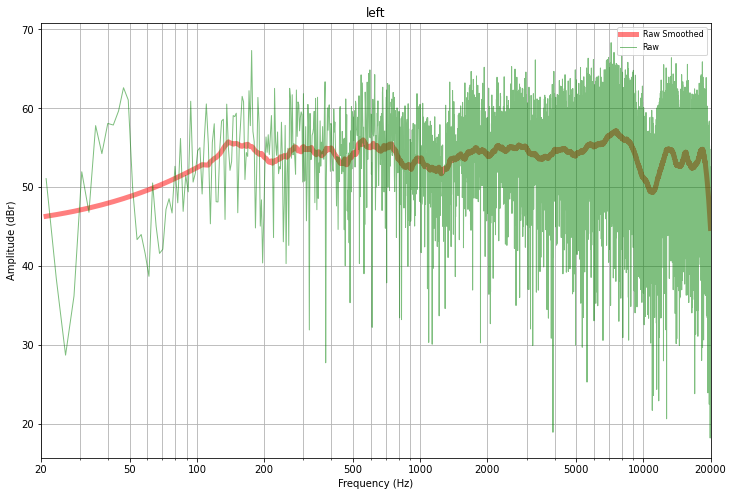

C:\Softwares\Python\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


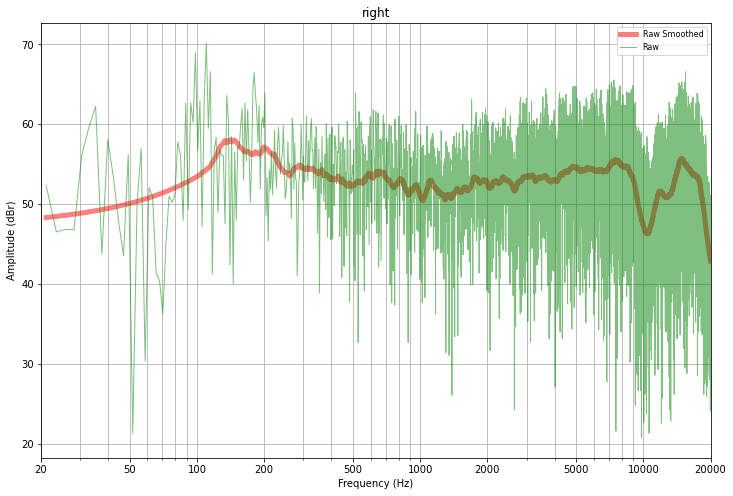

In [18]:
equalize_channels()    
probe_channels()

# PEQ settings

JamBox left PEQ filters:
  type  freq_Hz  gain_dB      Q
0   PK     17.6   -5.641  0.790
1   PK     73.5    4.077  1.046
2   PK    115.4    4.967  1.736
3   PK    190.0   -4.458  2.222
4   PK    461.8    2.323  6.414
5   PK   1231.0    7.732  1.202
6   PK   2237.7   -6.319  0.364
7   PK   4598.4   -5.094  1.102
8   PK   6865.9   -1.410  3.271
9   PK  10026.2   11.279  0.402

JamBox right PEQ filters:
  type  freq_Hz  gain_dB      Q
0   PK     57.9    6.526  0.826
1   PK     99.6    8.418  1.292
2   PK    238.4   -3.878  1.617
3   PK    657.6   -1.422  2.060
4   PK    995.2    3.489  1.354
5   PK   1454.5    2.563  2.586
6   PK   1893.3   -7.290  0.984
7   PK   3356.1   -4.460  2.359
8   PK   5902.2   -7.493  1.924
9   PK  10979.2   11.320  0.361



C:\Softwares\Python\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


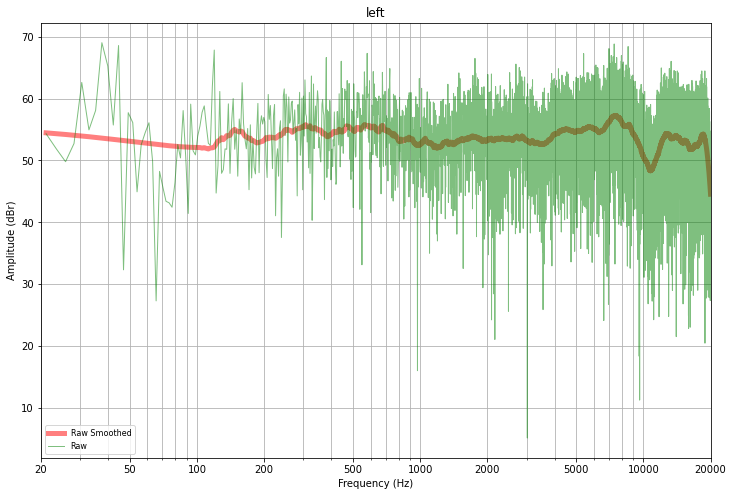

C:\Softwares\Python\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


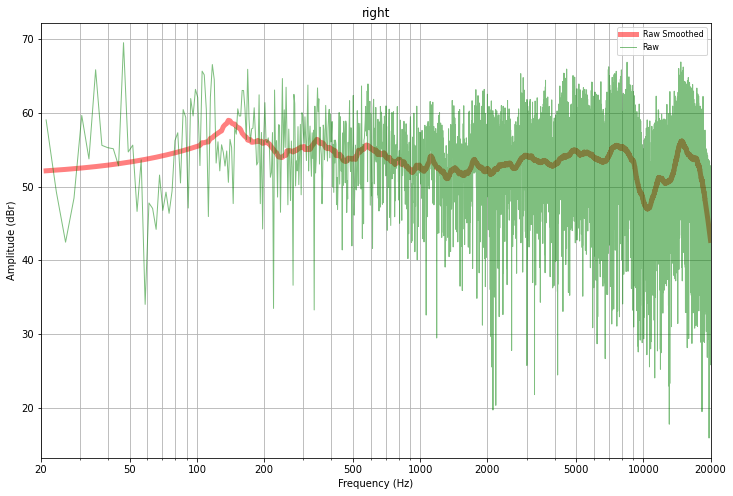

In [19]:
peqs = PEQs()

for channel_name in channels.keys():
    peqs.load(f'{model_name} {channel_name} PEQ filters.txt')
    set_peq_coeffs(channel_name, peqs.get_coefficient_sets_values(n_filters = n_filters))
    
    print(f'{model_name} {channel_name} PEQ filters:')
    print(pd.DataFrame(peqs.param_sets))
    print()    

probe_channels()

# Listen

In [20]:
source_select_normal()

# Close TCP channels

In [21]:
tcpi_client.stop()


[Client set to stop.]

[Connection with server ('192.168.203.36', 8086) is closed.]
